In [2]:
from utils import *
import numpy as np
import pandas as pd
from math import sqrt
from ing_theme_matplotlib import mpl_style
import matplotlib.pyplot as plt

In [3]:
"""Assumptions"""
# Initialize constants for the LP positions
INITIAL_PRICE = 1000
NUM_SIMULATIONS = 1  # fixed

# Constants for price simulations
SIGMA = 0.05  # similar to the 1-day volatility for ETH-USD
BASE_BLOCKTIME_SEC = 12
BLOCKS_PER_DAY = (
    86400 // BASE_BLOCKTIME_SEC
)  # assume 12 second blocks as in the mainnet
NUM_DAYS = 3

# assume 0.3% and 0.05% swap fees
SWAP_FEE_03 = 0.3 / 100
SWAP_FEE_005 = 0.05 / 100

# assume fixed gas fees

# swap transaction costs per transaction
# assume swap cost = 0
# tx_cost_bps = np.array([0.0, 0.001, 0.002, 0.005, 0.01, 0.02])
swap_tx_cost_dollars = np.array([0.0, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0])

# assume $1 million of liquidity in the pool (the larger, the better for all parties)
reserve_x = 500
reserve_y = 500000
pool_value0 = reserve_x * INITIAL_PRICE + reserve_y
L = get_liquidity(reserve_x, reserve_y)

# Constants for plotting
plt.rcParams["savefig.dpi"] = 200

# Generate sample CEX price
df_all = create_sample_df(
    SIGMA, blocks_per_day=BLOCKS_PER_DAY, M=NUM_SIMULATIONS, num_days=NUM_DAYS
)
print("shape:  ", df_all.shape)

all_prices = df_all["all_price"]

final_prices = all_prices.iloc[-1]
returns = final_prices / INITIAL_PRICE
year_sigma = SIGMA * sqrt(NUM_DAYS)  # convert from daily to yearly volatility
print("final_price: ", final_prices)
print(
    f"sigma={year_sigma:.2f} mean={np.mean(final_prices):.4f} std={np.std(np.log(returns)):.4f}"
)

shape:   (21600, 7)
final_price:  1119.532328911666
sigma=0.09 mean=1119.5323 std=0.0000


In [4]:
"""simulate LP, arbi performances"""

# initialize
cum_lp_pnl = (
    lp_pnl
) = lp_loss_vs_cex = lvr = collected_fees = swap_fee = arb_gain = num_tx = 0
pool_value = pool_value0
fee_tier = SWAP_FEE_03
swap_tx_cost = swap_tx_cost_dollars[0]
all_result = np.array([cum_lp_pnl, lvr, collected_fees])

# columns
# columns = ['t', 'Pool Price', 'Pool Value', 'x reserve', 'y reserve', 'collected fee', 'cum lvr', 'arb_gain']

# fee adjusted trade price(%)
fee_factor_down = 1.0 - fee_tier
fee_factor_up = 1.0 + fee_tier

for cex_price in all_prices:
    pool_price = reserve_y / reserve_x

    # no Tx happened
    if cex_price > pool_price:
        to_price = cex_price * fee_factor_down
        if to_price < pool_price:
            all_result = np.vstack((all_result, [cum_lp_pnl, lvr, collected_fees]))
            continue
    else:
        to_price = cex_price * fee_factor_up
        if to_price > pool_price:
            all_result = np.vstack((all_result, [cum_lp_pnl, lvr, collected_fees]))
            continue

    to_sqrt_price = sqrt(to_price)
    delta_x = L / to_sqrt_price - reserve_x
    delta_y = L * to_sqrt_price - reserve_y

    if delta_x > 0:
        # arber sells X, LP buys X
        swap_fee = fee_tier * delta_x * cex_price
    else:
        # arber buys X, LP sells X
        swap_fee = fee_tier * delta_y

    # R_t, assume fixed gas fees
    lp_loss_vs_cex = -(delta_x * cex_price + delta_y)

    # update gains of arbitrage
    arb_gain = lp_loss_vs_cex - swap_fee - swap_tx_cost

    # calculate LP P&L : V(t) - V(t-1) + Fee(t)

    if arb_gain > 0:
        lvr += lp_loss_vs_cex  # account without swap fees and tx fees

        reserve_x += delta_x
        reserve_y += delta_y

        # calculate new pool value
        new_pool_value = reserve_x * cex_price + reserve_y

        # lp pnl at the moment
        lp_pnl = new_pool_value - pool_value + swap_fee
        cum_lp_pnl += lp_pnl

        # fees collected so far
        collected_fees += swap_fee

        # update pool value
        pool_value = new_pool_value

        num_tx += 1

    all_result = np.vstack((all_result, [cum_lp_pnl, lvr, collected_fees]))
    # all_lvr.append(lp_loss_vs_cex)
    # all_cum_lvr.append(lvr)
    # all_fees.append(swap_fee)
    # all_cum_fees.append(collected_fees)

print("lvr: ", lvr, ", collected_fee: ", collected_fees, ", num_tx: ", num_tx)

lvr:  1068.039666792772 , collected_fee:  957.7196391875343 , num_tx:  2900


In [6]:
# normalize by dividing with the initial value of the capital rather than the final value
lvr /= pool_value0
collected_fees /= pool_value0
print("lvr: ", lvr, ", collected_fee: ", collected_fees, ", num_tx: ", num_tx)

lvr:  0.001068039666792772 , collected_fee:  0.0009577196391875343 , num_tx:  2900


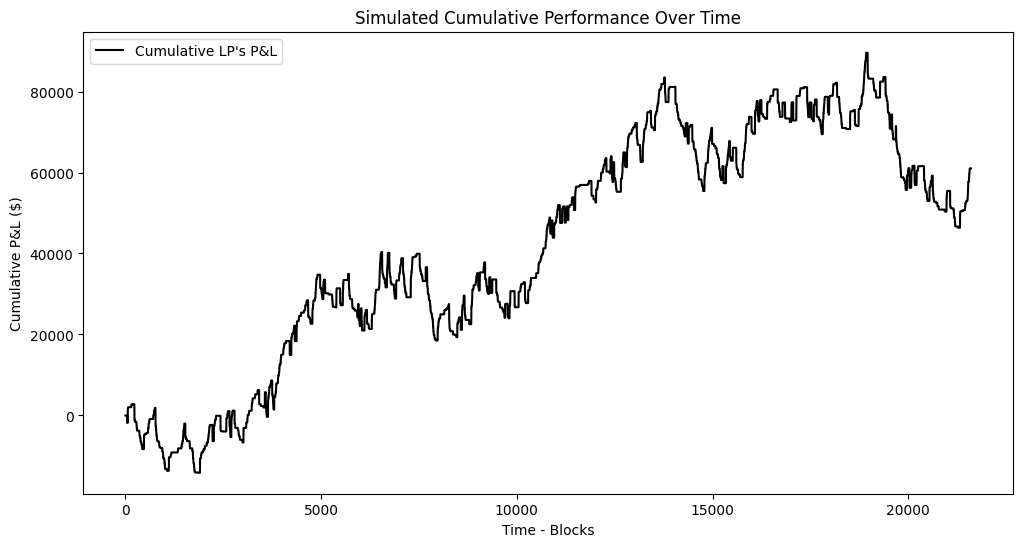

In [11]:
# Plotting
plt.figure(figsize=(12, 6))
num_block = np.arange(all_result.shape[0])  # sample for plotting
plt.plot(num_block, all_result[:, 0], label="Cumulative LP's P&L", color="black")
plt.xlabel("Time - Blocks")
plt.ylabel("Cumulative P&L ($)")
plt.title("Simulated Cumulative Performance Over Time")
plt.legend()

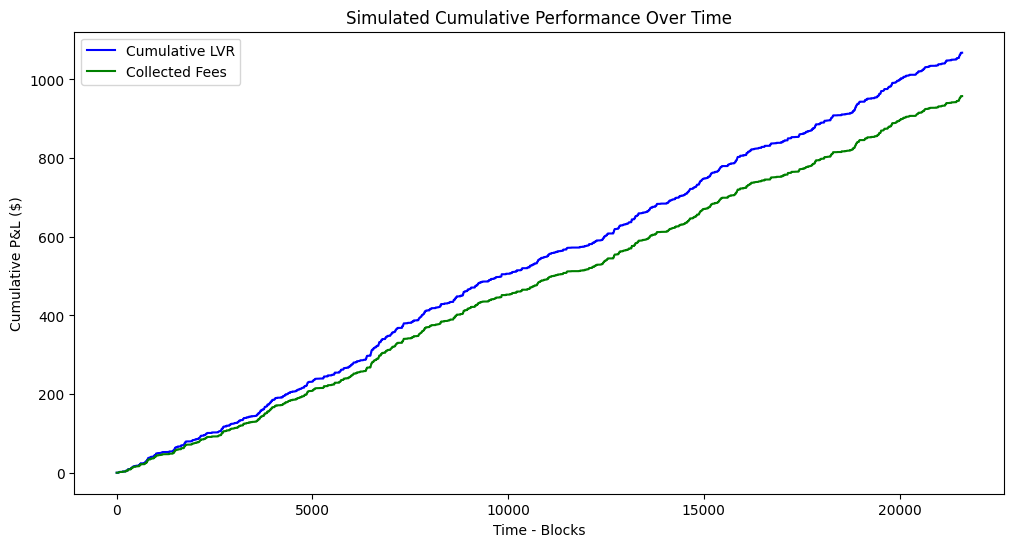

In [10]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(num_block, all_result[:, 1], label="Cumulative LVR", color="blue")
plt.plot(num_block, all_result[:, 2], label="Collected Fees", color="Green")
plt.xlabel("Time - Blocks")
plt.ylabel("Cumulative P&L ($)")
plt.title("Simulated Cumulative Performance Over Time")
plt.legend()